In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.cluster import OPTICS
import ast
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def import_tracks_from_sequence(filename):
  input = None

  with open(filename) as file:
    input = ast.literal_eval(file.readline())
  print ("finished reading the file")
  trackids = {element[1] for element in input}
  #print (trackids)

  tracks = {id : list() for id in trackids}

  for element in input:
    tracks[element[1]].append(element)
  
  #print(tracks)
  tracks_formatted = {id : format_track(track, id) for (id, track) in tracks.items()}
  tracks_print_basic_stats(tracks_formatted)

  return tracks_formatted

def tracks_print_basic_stats(tracks):
  lengths = np.array([len(track["frames"]) for (id, track) in tracks.items()])
  print ("number of tracks is ", len(tracks))
  print ("track length mean, std, and median are:", np.mean(lengths), np.std(lengths), np.median(lengths)) 

def format_track(track, trackid):
  length = len(track)
  output = dict()
  output["id"] = trackid
  output["type"] = track[0][2]
  output["frames"] = np.array([element[0] for element in track])
  xleft = np.array([element[3] for element in track])
  ytop = np.array([element[4] for element in track])
  xright = np.array([element[5] for element in track])
  ybottom = np.array([element[6] for element in track])
  output["x"] = 0.5 * (xleft + xright)
  output["y"] = 0.5 * (ytop + ybottom)
  output["height"] = ybottom - ytop
  output["width"] = xright - xleft
  #print(output)
  return output

In [4]:
def filter_tracks(tracks, minlength, maxgap, splitgap):

  temp = dict()

  for (id, track) in tracks.items():
    diffs = track["frames"][1:] - track["frames"][0:-1]
    ultrawide = [i+1 for i in range(len(diffs)) if diffs[i] > splitgap]
    if len(ultrawide) == 0:
      temp[id] = track
    else:
      print ("splitting track " + id + " into " + str(len(ultrawide) + 1) + " parts")
      
      starts = [0] + ultrawide
      ends = ultrawide + [len(track["frames"])]

      for i in range(len(starts)):
        tr = dict()
        tr["id"] = track["id"] + "." + str(i)
        tr["type"] = track["type"]
        tr["frames"] = track["frames"][starts[i] : ends[i]]
        tr["x"] = track["x"][starts[i] : ends[i]]
        tr["y"] = track["y"][starts[i] : ends[i]]
        tr["width"] = track["width"][starts[i] : ends[i]]
        tr["height"] = track["height"][starts[i] : ends[i]]        
        temp[tr["id"]] = tr

  def should_keep(track):
    if track["frames"][-1] - track["frames"][0] < minlength:
      return False
    for previous, next in zip(track["frames"][0:-1], track["frames"][1:]):
      if next - previous > maxgap:
        return False
    return True

  output = {id : track for (id, track) in temp.items() if should_keep(track)}

  tracks_print_basic_stats(output)

  return output

In [5]:
def interpolate_track(track, n_points):
  output = track.copy()
  timepoints = np.linspace(track["frames"][0], track["frames"][-1], n_points)
  output["frames"] = timepoints
  output["x"] = np.interp(timepoints, track["frames"], track["x"])
  output["y"] = np.interp(timepoints, track["frames"], track["y"])  
  output["height"] = np.interp(timepoints, track["frames"], track["height"])  
  output["width"] = np.interp(timepoints, track["frames"], track["width"])
  return output


In [47]:
def plot_tracks(tracks, screen_width, screen_height):
    plt.figure(dpi = 150)
    plt.xlim([0, screen_width])
    plt.ylim(screen_height, 0)
    for (id, track) in tracks.items():
      plt.plot(track["x"], track["y"])
    plt.show()



In [49]:
def tracks_stats(tracks, screen_width, screen_height, max_eps_div = 25.0, min_samples = 0.1):
  entry_clustering = cluster_points(tracks, 0, screen_width, screen_height, max_eps_div = max_eps_div, min_samples = min_samples)
  exit_clustering = cluster_points(tracks, -1, screen_width, screen_height, max_eps_div = max_eps_div, min_samples = min_samples)
  connections = match_ends(entry_clustering, exit_clustering)

  plt.figure(dpi = 150)
  plt.xlim([0, screen_width])
  plt.ylim(screen_height, 0)
  for pair in connections:
    plt.plot([entry_clustering["medians"]["x"][pair[0]], exit_clustering["medians"]["x"][pair[1]]] , [entry_clustering["medians"]["y"][pair[0]], exit_clustering["medians"]["y"][pair[1]]])
  plt.scatter(entry_clustering["medians"]["x"], entry_clustering["medians"]["y"], color="b", marker = 'o', s=80)
  plt.scatter(exit_clustering["medians"]["x"], exit_clustering["medians"]["y"], color="r", marker = "x", s=80)
  plt.show()

  return entry_clustering, exit_clustering, connections

def cluster_points(tracks, index, screen_width, screen_height, max_eps_div = 25.0, min_samples = 0.1):
  points = [(track["x"][index], track["y"][index]) for (id, track) in tracks.items()]
  max_eps = np.inf if max_eps_div is None else np.sqrt(screen_width**2 + screen_height**2) / max_eps_div
  clustering = OPTICS(min_samples = min_samples, metric = "euclidean", max_eps = max_eps, cluster_method = 'dbscan').fit(points)
  
  cluster_stats = {}
  cluster_stats["clustering"] = clustering

  get_cluster_stats(tracks, cluster_stats, index)

  plt.figure(dpi = 150)
  plt.xlim([0, screen_width])
  plt.ylim(screen_height, 0)
  plt.scatter([point[0] for point in points], [point[-1] for point in points], c=clustering.labels_, marker = '.')
  plt.scatter(cluster_stats["medians"]["x"], cluster_stats["medians"]["y"], color="r", marker = "x", s=80)
  plt.show()

  return cluster_stats

def get_cluster_stats(tracks, cluster_stats, index):
  clustering = cluster_stats["clustering"]
  tracks = [track for (id, track) in tracks.items()]

  n_clusters = np.max(clustering.labels_) + 1

  def cluster_median(key):
    cluster_median = []
    cluster_std = []
    for cl in range(n_clusters):
      values = [track[key][index] for (track, label) in zip(tracks, clustering.labels_)  if label == cl]
      cluster_median.append(np.median(values))
      cluster_std.append(np.std(values))
    return np.array(cluster_median), np.array(cluster_std)
  
  keys = ["x", "y", "width", "height"]
  cluster_stats["medians"] = {}
  cluster_stats["stds"] = {}
  for key in keys:
    medians, stds = cluster_median(key)
    cluster_stats["medians"][key] = medians
    cluster_stats["stds"][key] = stds

def match_ends(entry_clustering, exit_clustering, cover_fraction = 0.95):
  count = 0
  connection_matrix = np.zeros((len(entry_clustering["medians"]["x"]), len(exit_clustering["medians"]["x"])))
  for entry, exit in zip (entry_clustering["clustering"].labels_, exit_clustering["clustering"].labels_):
    if entry == -1 or exit == -1:
      continue
    count += 1
    connection_matrix[entry, exit] += 1
  connection_matrix = connection_matrix / count
  flattened_matrix = list(np.ndenumerate(connection_matrix))
  flattened_matrix.sort(reverse = True, key = lambda x : x[-1])
  for item in flattened_matrix:
    print(item)
  cummulant = 0
  output = list()
  for item in flattened_matrix:
    output.append(item[0])
    cummulant += item[-1]
    if cummulant > cover_fraction:
      break
  print(output)
  return output

def get_nice_trajectories(tracks, entry_clustering, exit_clustering):
  good_tracks = dict()
  for i, (id, track) in enumerate(tracks.items()):
    if entry_clustering["clustering"].labels_[i] != -1 and exit_clustering["clustering"].labels_[i] != -1:
      good_tracks[track["id"]] = track
  return good_tracks

def cluster_points_4D(tracks, screen_width, screen_height, max_eps_div = 25.0, min_samples = 0.1):
  points = [(track["x"][0], track["y"][0], track["x"][-1], track["y"][-1]) for (id, track) in tracks.items()]

  max_eps = np.inf if max_eps_div is None else np.sqrt(2.0) * np.sqrt(screen_width**2 + screen_height**2) / max_eps_div
  clustering = OPTICS(min_samples = min_samples, metric = "euclidean", max_eps = max_eps, cluster_method = 'dbscan').fit(points)
  
  cluster_stats_entries = {}
  cluster_stats_entries["clustering"] = clustering

  get_cluster_stats(tracks, cluster_stats_entries, 0)

  plt.figure(dpi = 150)
  plt.xlim([0, screen_width])
  plt.ylim(screen_height, 0)
  plt.scatter([point[0] for point in points], [point[1] for point in points], c=clustering.labels_, marker = '.')
  plt.scatter(cluster_stats_entries["medians"]["x"], cluster_stats_entries["medians"]["y"], color="r", marker = "x", s=80)
  plt.show()

  cluster_stats_exits = {}
  cluster_stats_exits["clustering"] = clustering

  get_cluster_stats(tracks, cluster_stats_exits, -1)

  plt.figure(dpi = 150)
  plt.xlim([0, screen_width])
  plt.ylim(screen_height, 0)
  plt.scatter([point[2] for point in points], [point[3] for point in points], c=clustering.labels_, marker = '.')
  plt.scatter(cluster_stats_exits["medians"]["x"], cluster_stats_exits["medians"]["y"], color="r", marker = "x", s=80)
  plt.show()

  return cluster_stats_entries, cluster_stats_exits

def tracks_stats_4D(tracks, screen_width, screen_height, max_eps_div = 25.0, min_samples = 0.1):

  entry_clustering, exit_clustering = cluster_points_4D(tracks, screen_width, screen_height, max_eps_div = max_eps_div, min_samples = min_samples)
  n_connections = len(entry_clustering["medians"]["x"])

  connections = [(i,i) for i in range(n_connections)]

  plt.figure(dpi = 150)
  plt.xlim([0, screen_width])
  plt.ylim(screen_height, 0)
  for pair in connections:
    plt.plot([entry_clustering["medians"]["x"][pair[0]], exit_clustering["medians"]["x"][pair[1]]] , [entry_clustering["medians"]["y"][pair[0]], exit_clustering["medians"]["y"][pair[1]]])
  plt.scatter(entry_clustering["medians"]["x"], entry_clustering["medians"]["y"], color="b", marker = 'o', s=80)
  plt.scatter(exit_clustering["medians"]["x"], exit_clustering["medians"]["y"], color="r", marker = "x", s=80)
  plt.show()
  
  return entry_clustering, exit_clustering, connections


In [50]:
def normalize_tracks(tracks, entries, exits, connections):
  def find_matching_connection(track, entries, exits, connections):
    mindistance = np.inf
    for i, j in connections:
      distance  = (((track["x"][0] - entries["medians"]["x"][i]) / entries["stds"]["x"][i])**2 + 
                  ((track["y"][0] - entries["medians"]["y"][i]) / entries["stds"]["y"][i])**2 + 
                  ((track["x"][-1] - exits["medians"]["x"][j]) / exits["stds"]["x"][j])**2 + 
                  ((track["y"][-1] - exits["medians"]["y"][j]) / exits["stds"]["y"][j])**2)
      if distance < mindistance:
        mindistance = distance
        solution = i, j
    return solution

  for (id, track) in tracks.items():

    median_entry, median_exit = find_matching_connection(track, entries, exits, connections)

    median_entry_point = entries["medians"]["x"][median_entry], entries["medians"]["y"][median_entry]
    median_exit_point = exits["medians"]["x"][median_exit], exits["medians"]["y"][median_exit]
    
    normalize_track(track, median_entry, median_exit, median_entry_point, median_exit_point)

  plot_normalized_tracks(tracks)


def normalize_track(track, median_entry, median_exit, median_entry_point, median_exit_point):
    track["x_norm"] = (track["x"] - median_entry_point[0]) / (median_exit_point[0] - median_entry_point[0])
    track["y_norm"] = (track["y"] - median_entry_point[1]) / (median_exit_point[1] - median_entry_point[1])
    track["t_norm"] = (track["frames"] - track["frames"][0]) / (track["frames"][-1] - track["frames"][0])

    track["cluster_entry"] = median_entry
    track["cluster_exit"] = median_exit
    track["cluster_entry_point"] = median_entry_point
    track["cluster_exit_point"] = median_exit_point

def plot_normalized_tracks(tracks):
  plt.figure(dpi = 150)
  plt.xlabel = "x"
  plt.ylabel = "y"
  for (id, track) in tracks.items():
    plt.plot(track["x_norm"], track["y_norm"])
  plt.xlim(-1, 2)
  plt.ylim(-1, 2)
  plt.show()

  plt.figure(dpi = 150)
  plt.xlabel = "t"
  plt.ylabel = "x"
  for (id, track) in tracks.items():
    plt.plot(track["t_norm"], track["x_norm"])
  plt.xlim(0, 1)
  plt.ylim(-1, 2)
  plt.show()

  plt.figure(dpi = 150)
  plt.xlabel = "t"
  plt.ylabel = "y"
  for (id, track) in tracks.items():
    plt.plot(track["t_norm"], track["y_norm"])
  plt.xlim(0, 1)
  plt.ylim(-1, 2)
  plt.show()



In [51]:
def pause_anomalies(normed_tracks, n_anomalies, min_pause, max_pause):
  anomalies = dict();
  n_tracks = len(normed_tracks)
  keylist = list(normed_tracks.keys())
  length_track = len(normed_tracks[keylist[0]]["frames"])
  for i in range(n_anomalies):
    key = keylist[np.random.randint(0, n_tracks)]
    track = normed_tracks[key]
    pause_position = np.random.randint(0, length_track-1)
    pause_length = np.random.random() * (max_pause - min_pause) + min_pause

    ano_track = dict()

    ano_track["id"] = track["id"] + ".ano.pause." + str(i)
    ano_track["type"] = track["type"]
    ano_track["x"] = np.copy(track["x"])
    ano_track["y"] = np.copy(track["y"])
    ano_track["height"] = np.copy(track["height"])
    ano_track["width"] = np.copy(track["width"])

    ano_track["frames"] = np.copy(track["frames"])
    ano_track["frames"][pause_position:] = track["frames"][pause_position:] + pause_length

    ano_track = interpolate_track(ano_track, length_track)
    normalize_track(ano_track, track["cluster_entry"], track["cluster_exit"], track["cluster_entry_point"], track["cluster_exit_point"])

    anomalies[ano_track["id"]] = ano_track

  plot_normalized_tracks(anomalies)

  return anomalies

def speedup_anomalies(normed_tracks, n_anomalies, min_speedup, max_speedup, min_frames, max_frames):
  anomalies = dict();
  n_tracks = len(normed_tracks)
  keylist = list(normed_tracks.keys())
  length_track = len(normed_tracks[keylist[0]]["frames"])
  for i in range(n_anomalies):
    key = keylist[np.random.randint(0, n_tracks)]
    track = normed_tracks[key]
    speedup_range = np.random.randint(min_frames, max_frames + 1)
    speedup_position = np.random.randint(0, length_track - speedup_range - 1)

    speedup_rate = np.random.random() * (min_speedup - max_speedup) + min_speedup

    ano_track = dict()

    ano_track["id"] = track["id"] + ".ano.speedup." + str(i)
    ano_track["type"] = track["type"]
    ano_track["x"] = np.copy(track["x"])
    ano_track["y"] = np.copy(track["y"])
    ano_track["height"] = np.copy(track["height"])
    ano_track["width"] = np.copy(track["width"])

    ano_track["frames"] = np.copy(track["frames"])
    ano_track["frames"][speedup_position : speedup_position + speedup_range] = track["frames"][speedup_position] + (track["frames"][speedup_position : speedup_position + speedup_range] - track["frames"][speedup_position]) / speedup_rate
    ano_track["frames"][speedup_position + speedup_range:] = (track["frames"][speedup_position + speedup_range:] - track["frames"][speedup_position + speedup_range - 1]) + ano_track["frames"][speedup_position + speedup_range - 1]
    
    ano_track = interpolate_track(ano_track, length_track)
    normalize_track(ano_track, track["cluster_entry"], track["cluster_exit"], track["cluster_entry_point"], track["cluster_exit_point"])

    anomalies[ano_track["id"]] = ano_track

  plot_normalized_tracks(anomalies)

  return anomalies

def reversetime_anomalies(normed_tracks, n_anomalies, entries, exits, connections):
  anomalies = dict();
  n_tracks = len(normed_tracks)
  keylist = list(normed_tracks.keys())
  length_track = len(normed_tracks[keylist[0]]["frames"])
  for i in range(n_anomalies):
    key = keylist[np.random.randint(0, n_tracks)]
    track = normed_tracks[key]

    ano_track = dict()

    ano_track["id"] = track["id"] + ".ano.timeflip." + str(i)
    ano_track["type"] = track["type"]
    ano_track["x"] = np.flip(track["x"])
    ano_track["y"] = np.flip(track["y"])
    ano_track["height"] = np.flip(track["height"])
    ano_track["width"] = np.flip(track["width"])
    ano_track["frames"] = np.copy(track["frames"])

    anomalies[ano_track["id"]] = ano_track
  
  normalize_tracks(anomalies, entries, exits, connections)

  return anomalies

def wrong_exit_anomalies(normed_tracks, n_anomalies, entries, exits, connections):
  anomalies = dict();
  n_tracks = len(normed_tracks)
  keylist = list(normed_tracks.keys())
  length_track = len(normed_tracks[keylist[0]]["frames"])
  for i in range(n_anomalies):
    key = keylist[np.random.randint(0, n_tracks)]
    track = normed_tracks[key]

    n_exits = len(exits["medians"]["y"])
    track_entry = track["cluster_entry"]
    track_exit = track["cluster_exit"]

    valid_exits = [j for i, j in connections if track_entry == i]
    invalid_exits = [i for i in range(n_exits) if i not in valid_exits]
    if len(invalid_exits) == 0:
      continue
    wrong_exit = invalid_exits[np.random.randint(0, len(invalid_exits))]

    ano_track = dict()

    ano_track["id"] = track["id"] + ".ano.speedup." + str(i)
    ano_track["type"] = track["type"]
    ano_track["height"] = np.copy(track["height"])
    ano_track["width"] = np.copy(track["width"])
    ano_track["frames"] = np.copy(track["frames"])

    median_entry_point = entries["medians"]["x"][track_entry], entries["medians"]["y"][track_entry]
    median_exit_point = exits["medians"]["x"][wrong_exit], exits["medians"]["y"][wrong_exit]

    ano_track["x"] = median_entry_point[0] + track["x_norm"] * (median_exit_point[0] - median_entry_point[0])
    ano_track["y"] = median_entry_point[1] + track["y_norm"] * (median_exit_point[1] - median_entry_point[1])

    anomalies[ano_track["id"]] = ano_track
  
  normalize_tracks(anomalies, entries, exits, connections)

  return anomalies

def wrong_entry_anomalies(normed_tracks, n_anomalies, entries, exits, connections):
  anomalies = dict();
  n_tracks = len(normed_tracks)
  keylist = list(normed_tracks.keys())
  length_track = len(normed_tracks[keylist[0]]["frames"])
  for i in range(n_anomalies):
    key = keylist[np.random.randint(0, n_tracks)]
    track = normed_tracks[key]

    n_entries = len(entries["medians"]["y"])
    track_entry = track["cluster_entry"]
    track_exit = track["cluster_exit"]

    valid_entries = [i for i, j in connections if track_exit == j]
    invalid_entries = [i for i in range(n_entries) if i not in valid_entries]
    if len(invalid_entries) == 0:
      continue
    wrong_entry = invalid_entries[np.random.randint(0, len(invalid_entries))]

    ano_track = dict()

    ano_track["id"] = track["id"] + ".ano.speedup." + str(i)
    ano_track["type"] = track["type"]
    ano_track["height"] = np.copy(track["height"])
    ano_track["width"] = np.copy(track["width"])
    ano_track["frames"] = np.copy(track["frames"])

    median_entry_point = entries["medians"]["x"][wrong_entry], entries["medians"]["y"][wrong_entry]
    median_exit_point = exits["medians"]["x"][track_exit], exits["medians"]["y"][track_exit]

    ano_track["x"] = median_entry_point[0] + track["x_norm"] * (median_exit_point[0] - median_entry_point[0])
    ano_track["y"] = median_entry_point[1] + track["y_norm"] * (median_exit_point[1] - median_entry_point[1])

    anomalies[ano_track["id"]] = ano_track
  
  normalize_tracks(anomalies, entries, exits, connections)

  return anomalies



In [12]:
def export_trajectories(trajectories, filename):
  arrays_coordinates = [(track['x'], track['y']) for (key, track) in trajectories.items()]
  np.save(filename + "_RAW", arrays_coordinates)
  arrays_coordinates = [(track['x_norm'], track['y_norm']) for (key, track) in trajectories.items()]
  np.save(filename + "_NOR", arrays_coordinates)
  

# Example on small data 

First we read tracks from the tracker output for each individual sequence

In [32]:
tracks = import_tracks_from_sequence("/content/drive/MyDrive/aaa/video_highway_3_trajectories.txt")

finished reading the file
number of tracks is  66
track length mean, std, and median are: 88.81818181818181 72.22332979301899 80.5


Then we remove tracks that last for less than 30 frames, or have a gap in detections larger than 20 frames. We also split tracks with exceptionally large detection gaps (200 frames) into separate tracks presuming the same id was used on multiple vehicles.



In [33]:
tracks_filtered = filter_tracks(tracks, 30, 20, 200)

number of tracks is  32
track length mean, std, and median are: 104.28125 52.759616644148394 96.0


Now we make trajectories have uniform size (50 time points that are equally spaced). Vehicle position at these timepoints is estimated by linear interpolation between nearest original data points.

In [34]:
tracks_interpolated = {id: interpolate_track(track, 50) for (id, track) in tracks_filtered.items()}
#print (tracks_interpolated)
tracks_print_basic_stats(tracks_interpolated)

number of tracks is  32
track length mean, std, and median are: 50.0 0.0 50.0


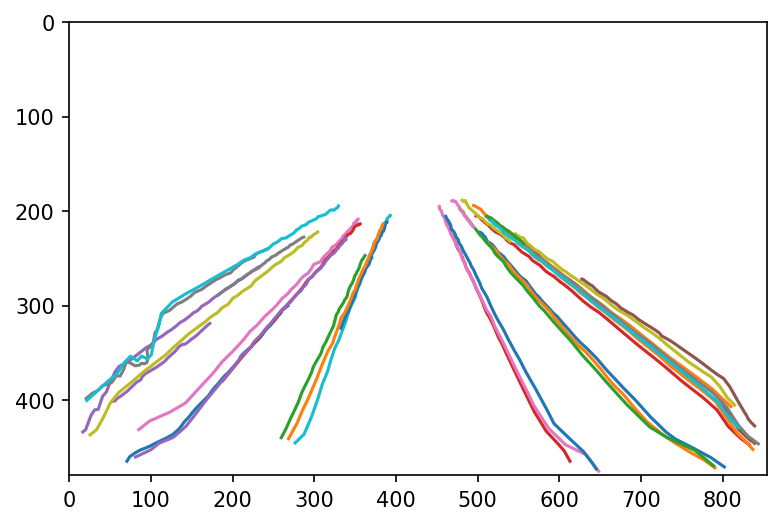

In [60]:
plot_tracks(tracks_interpolated, 854, 480)

We extract entry and exit points (the first and the last frame) for each track and cluster them. We use OPTICS clustering algo that does not require specifying the number of clusters a priori (but does have other finicky parameters to tweak). We find the medians of these clusters and pair matching entry and exit medians corresponding to frequent vehicle paths. These we treat as 'normal' driving modes. These will be used to normalize trajectories. 

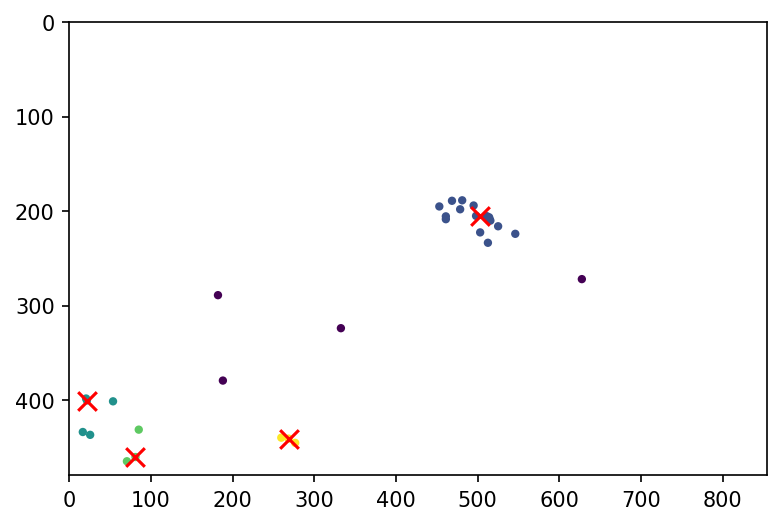

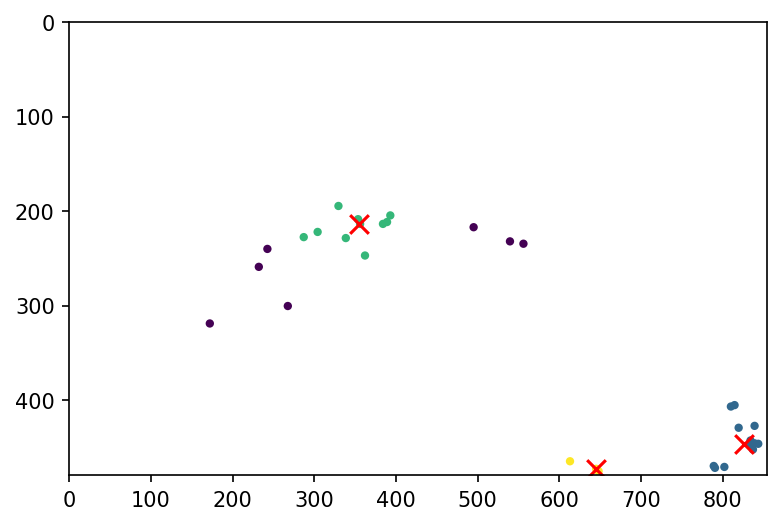

((0, 0), 0.5238095238095238)
((0, 2), 0.14285714285714285)
((3, 1), 0.14285714285714285)
((1, 1), 0.09523809523809523)
((2, 1), 0.09523809523809523)
((0, 1), 0.0)
((1, 0), 0.0)
((1, 2), 0.0)
((2, 0), 0.0)
((2, 2), 0.0)
((3, 0), 0.0)
((3, 2), 0.0)
[(0, 0), (0, 2), (3, 1), (1, 1), (2, 1)]


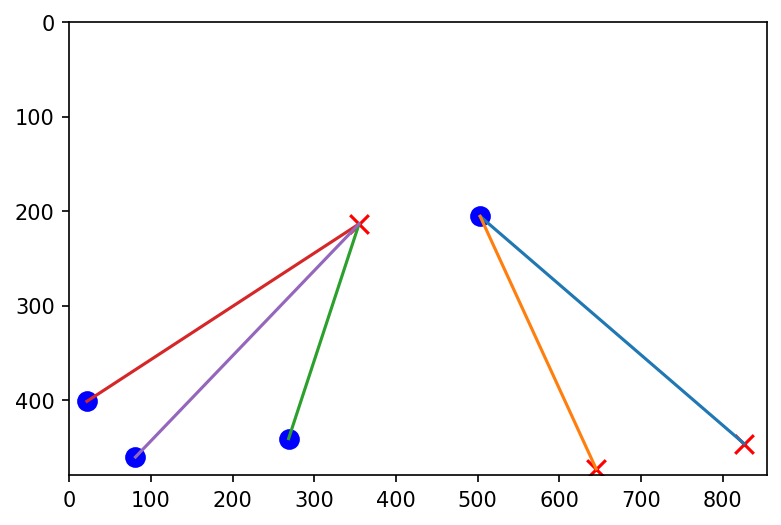

{'clustering': OPTICS(algorithm='auto', cluster_method='dbscan', eps=None, leaf_size=30,
       max_eps=39.186038329997075, metric='euclidean', metric_params=None,
       min_cluster_size=None, min_samples=0.1, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05), 'medians': {'x': array([503. ,  21.5,  81. , 268.5]), 'y': array([205.5, 401.5, 460.5, 441. ]), 'width': array([ 15.,  33., 174., 105.]), 'height': array([13., 81., 39., 78.])}, 'stds': {'x': array([25.12876872, 13.31164903,  6.11464544,  6.94422222]), 'y': array([11.87317642, 17.36260349, 14.84550063,  2.39211668]), 'width': array([ 3.90279822, 26.6653333 , 13.49073756,  7.36357401]), 'height': array([ 3.56841197, 35.95886539, 29.69100126,  5.18544973])}}
{'clustering': OPTICS(algorithm='auto', cluster_method='dbscan', eps=None, leaf_size=30,
       max_eps=39.186038329997075, metric='euclidean', metric_params=None,
       min_cluster_size=None, min_samples=0.1, n_jobs=None, p=2,
       predecessor_correction=True,

In [52]:
entries, exits, connections = tracks_stats(tracks_interpolated, 854, 480)
print(entries)
print(exits)
print(connections)

We normalize tracks by finding their closest match among the valid entry-exit connections (this is done by comapring the distances from track's entry and exit points and those of the connection pair). The x and y values of the track's trajectory are scaled in such a way that a trajectory going exactly from the median entry to median exit and moving across the screen at constant velocity would rescale to a trajectory moving steadily from (0,0) to (1,1) in the rescaled coordinates.

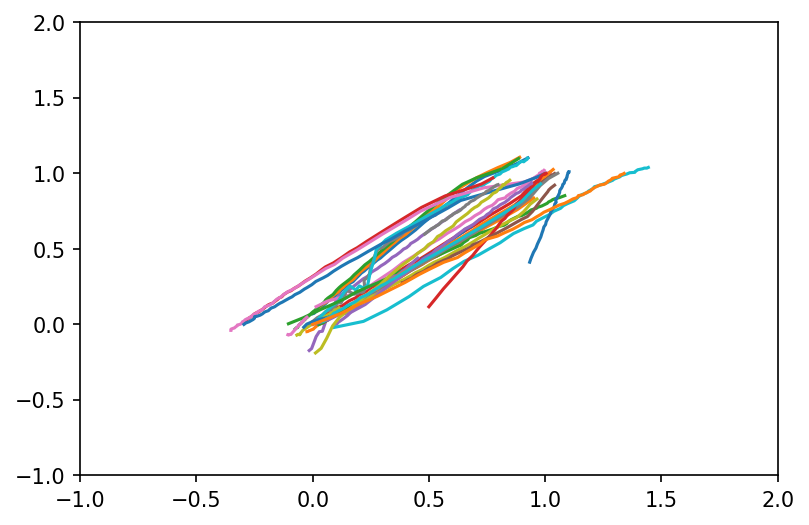

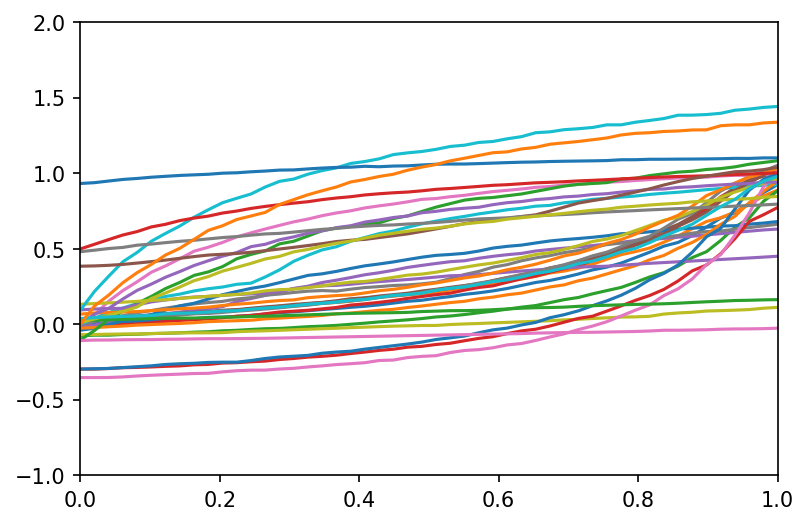

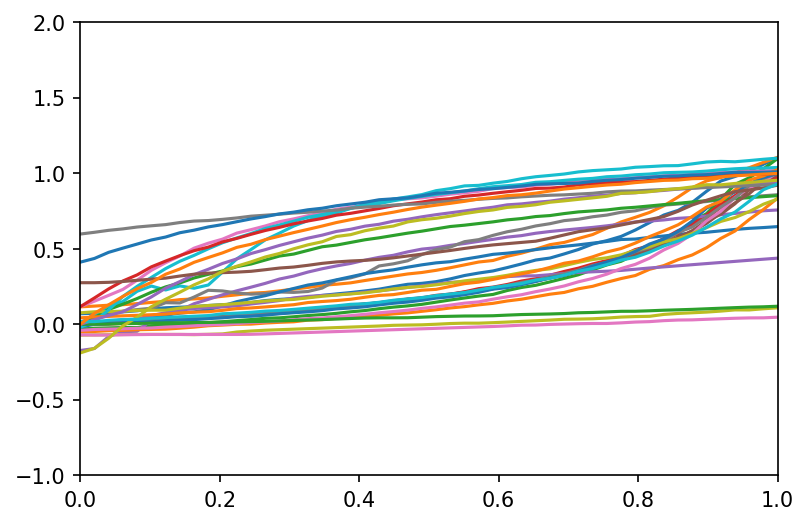

In [53]:
normalize_tracks(tracks_interpolated, entries, exits, connections)

We can create synthetic anomalous tracks by sampling from valid normalized trajectories and applying some transformation. 

For example we can sample 50 trajectories and insert a random-duration pause ranging from 50 t0 500 frames at a random position in the trajectory. The vehicle would suddenly stop on the road and later continue moving. 

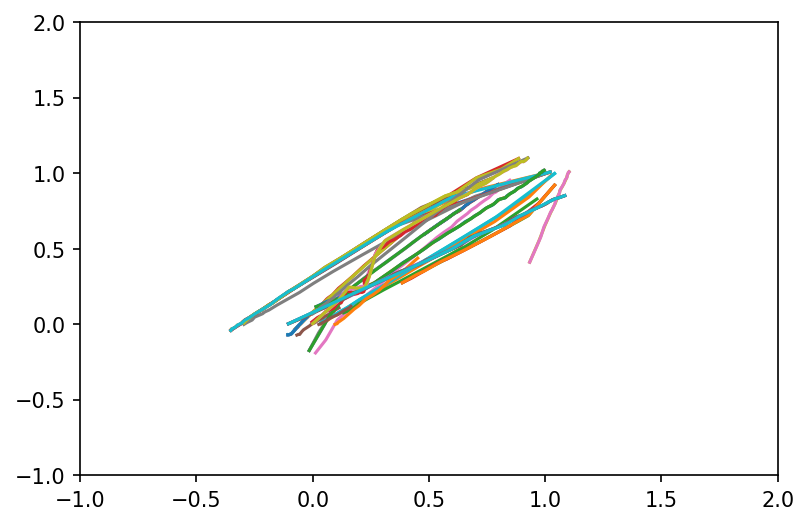

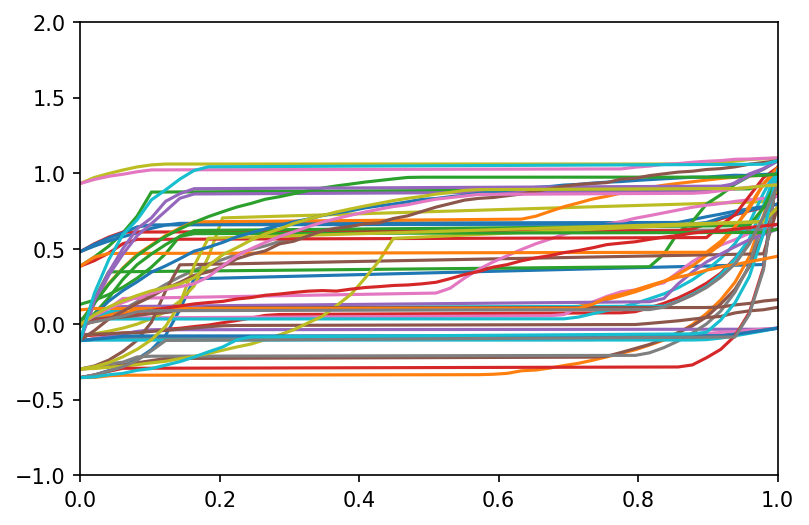

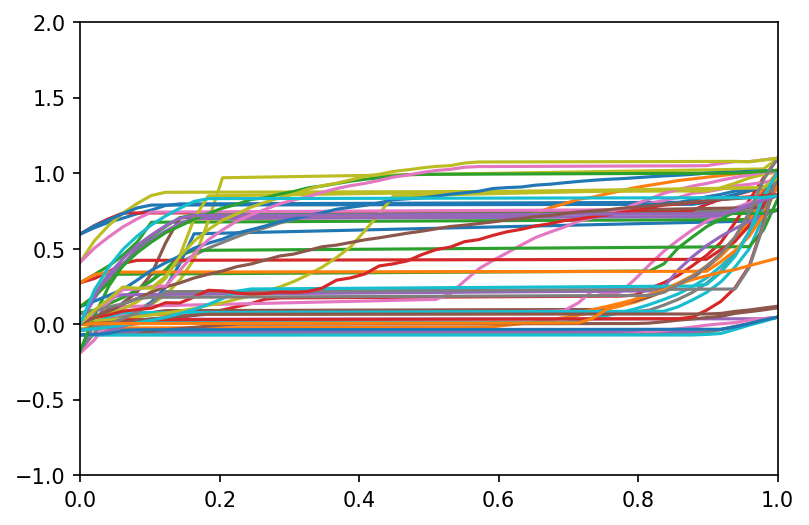

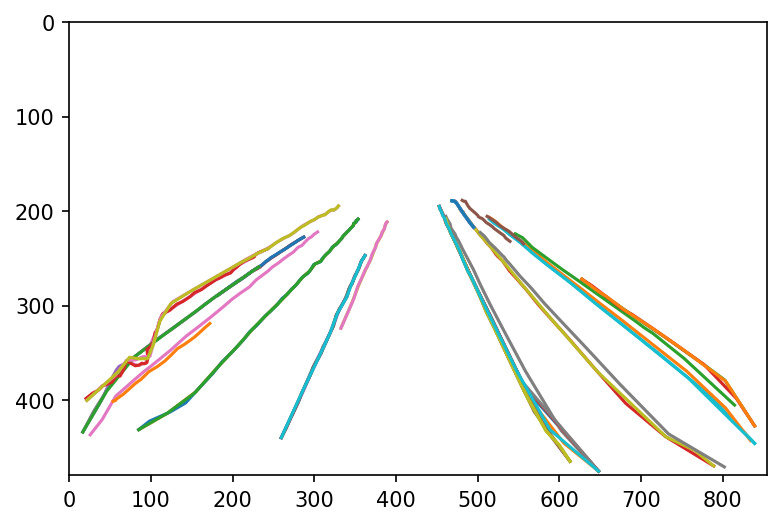

In [61]:
ano_tracks_pause = pause_anomalies(tracks_interpolated, 50, 50, 500)
plot_tracks(ano_tracks_pause, 854, 480)

Alternatively, we can sample 50 trajectories and in each select a range of 15 to 35 sequential timepoints and squish their frame-signature so that they are effectively sped-up from 8 to 16 times.

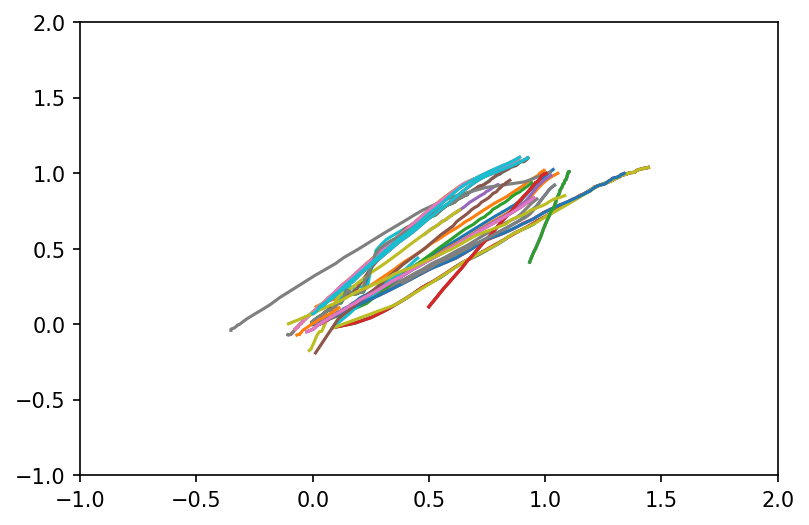

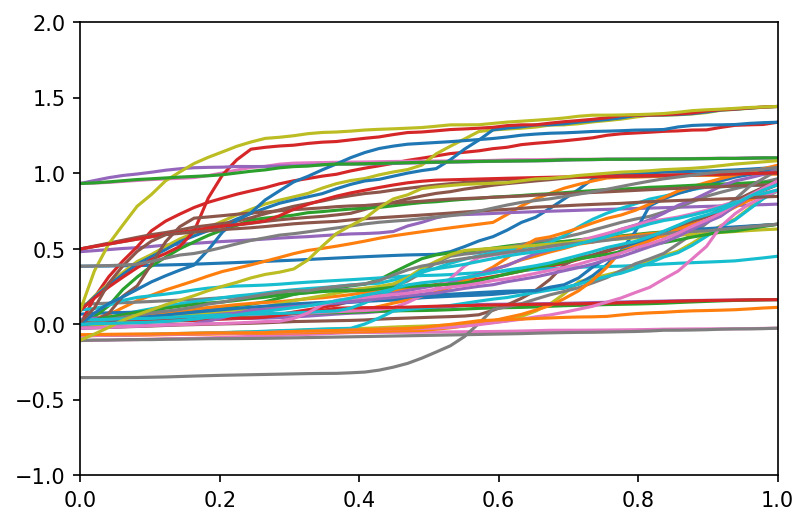

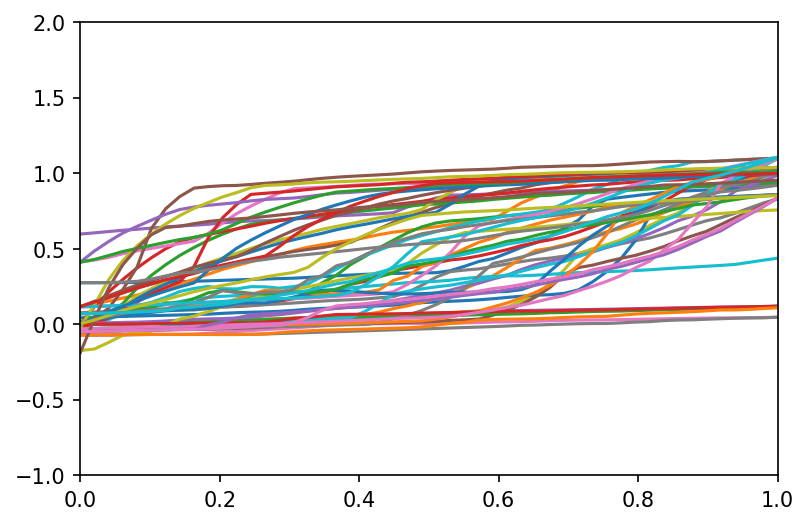

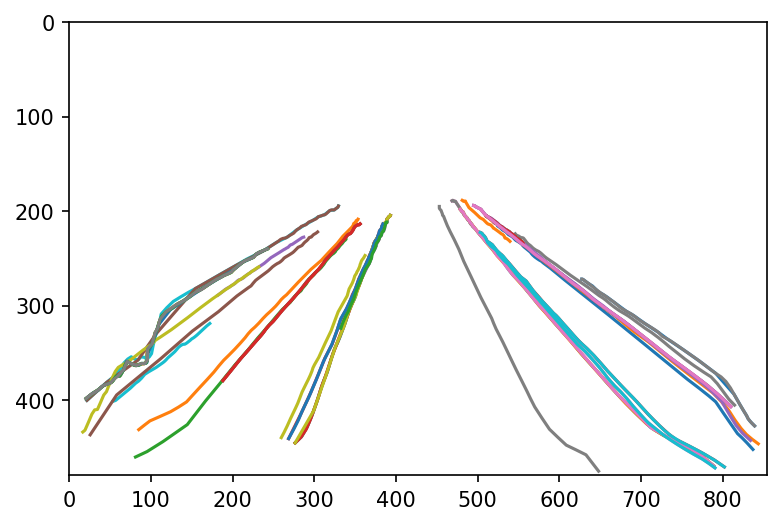

In [62]:
ano_speedups = speedup_anomalies(tracks_interpolated, 50, 8., 16., 15, 35)
plot_tracks(ano_speedups, 854, 480)

We can reverse the direction of time making cars appear to drive in the wrong direction. Tracks are renormalized since now they have to be re-matched to find best entry-exit connection to scale coordinates to.

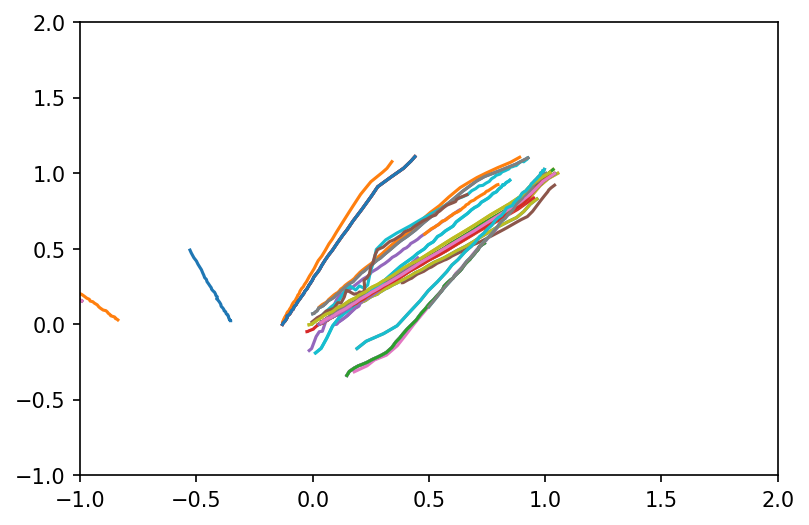

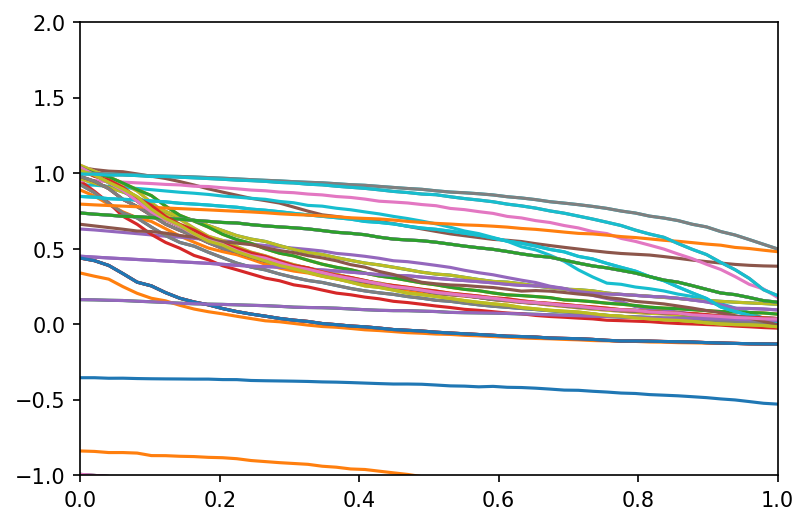

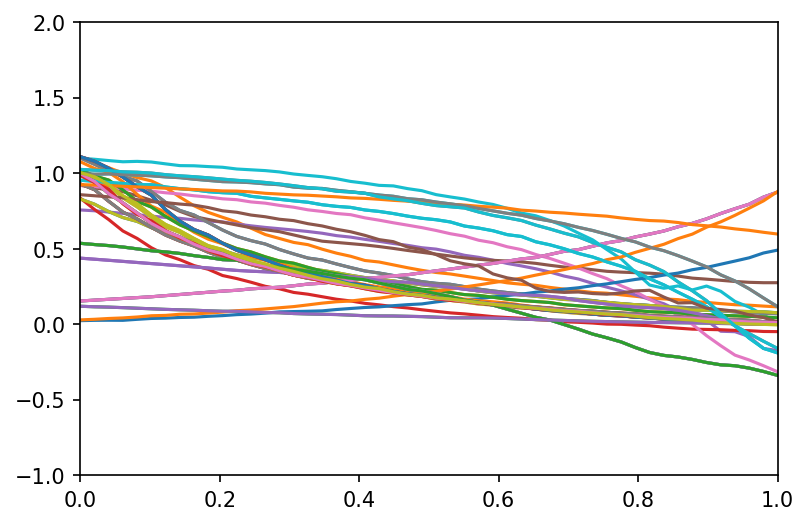

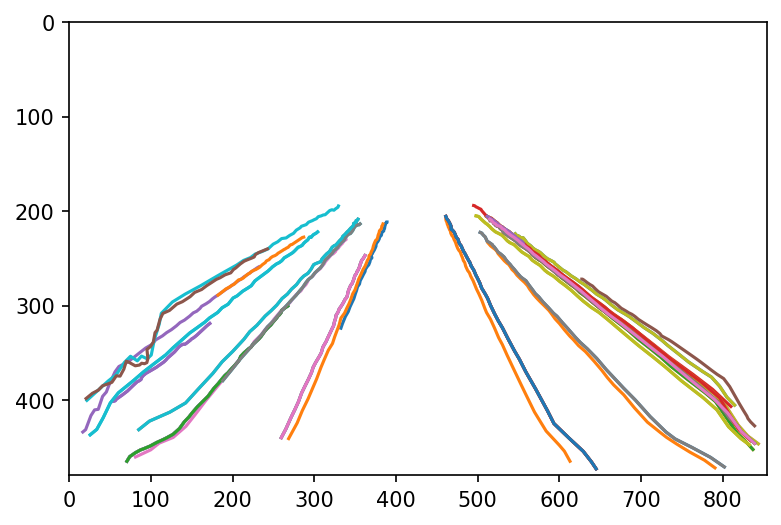

In [63]:
ano_timeflip = reversetime_anomalies(tracks_interpolated, 50, entries, exits, connections)
plot_tracks(ano_timeflip, 854, 480)

Another way to synthesize an anomaly is to assign it an invalid exit given its median entry point, and work back its x and y coordinates given its normalized coordinates (but now with the wrong exit). Then renormalize. 

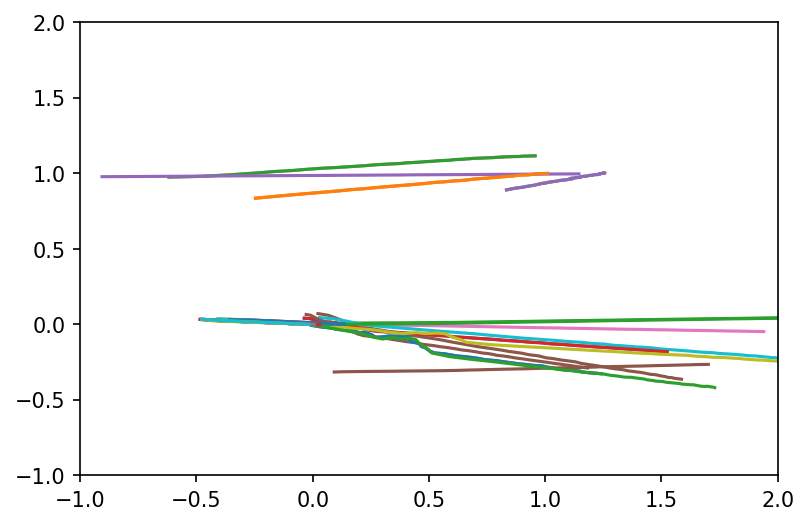

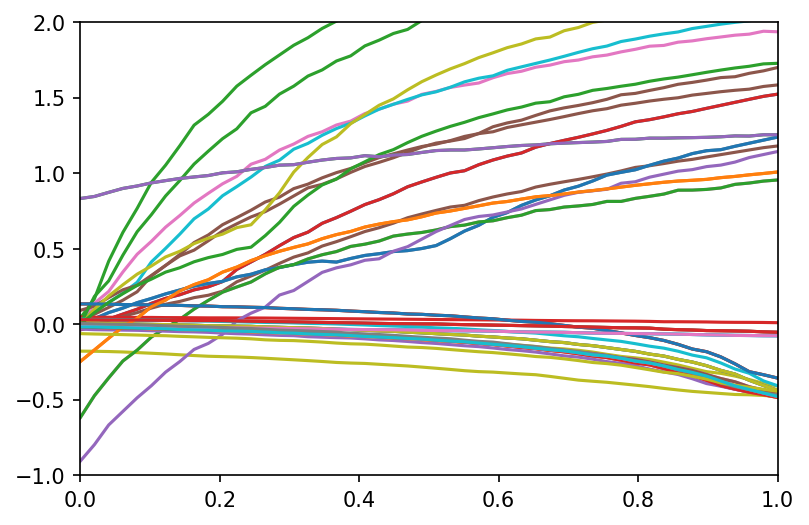

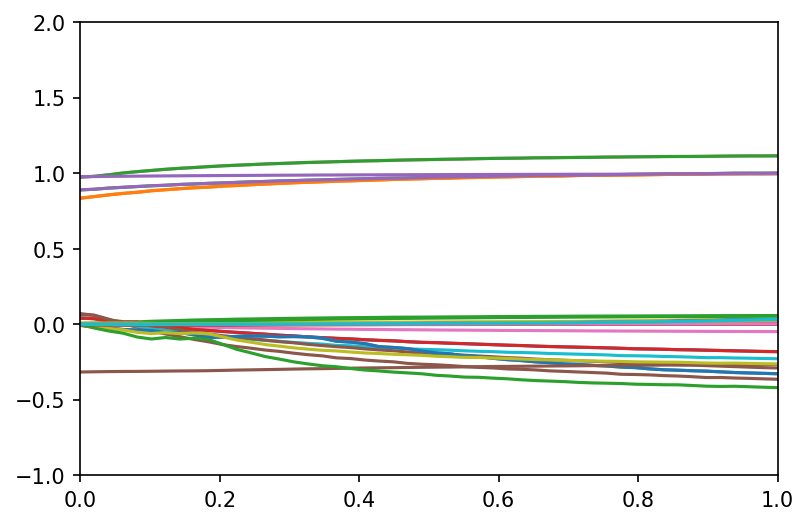

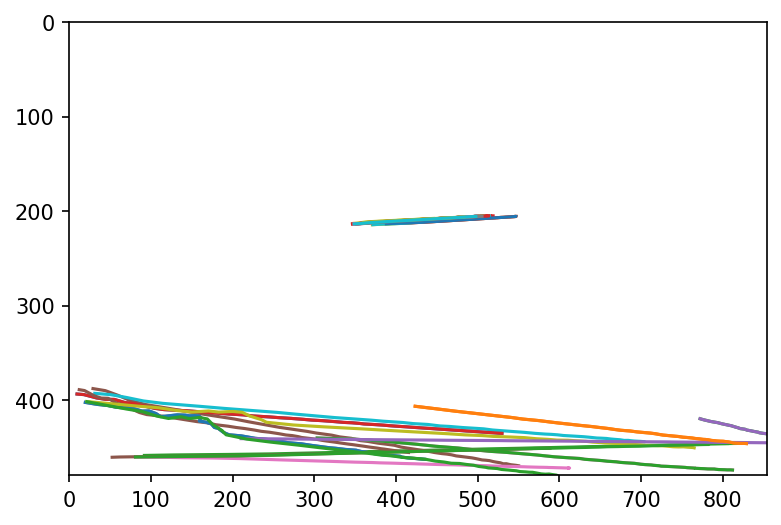

In [64]:
ano_wrongexit = wrong_exit_anomalies(tracks_interpolated, 50, entries, exits, connections)
plot_tracks(ano_wrongexit, 854, 480)

Or the same thing but with an invalid entry point.

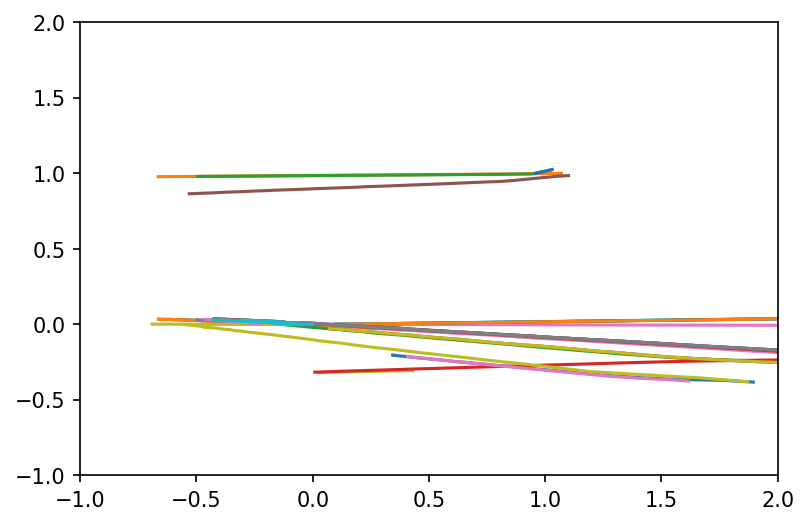

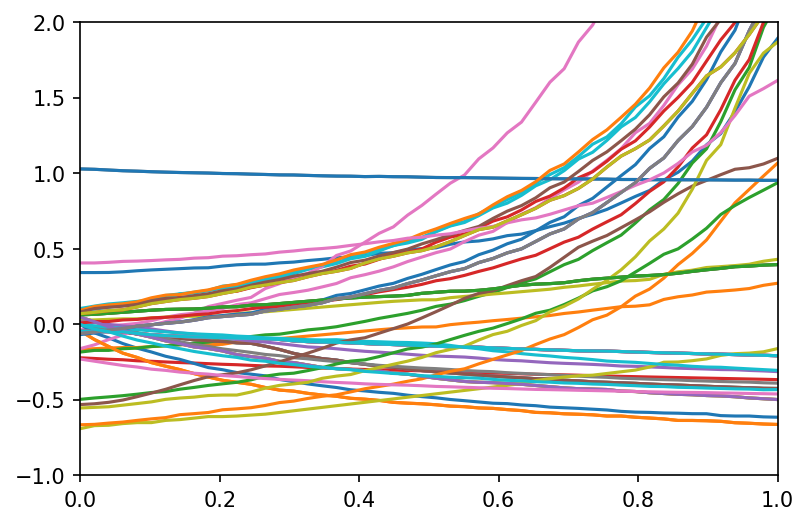

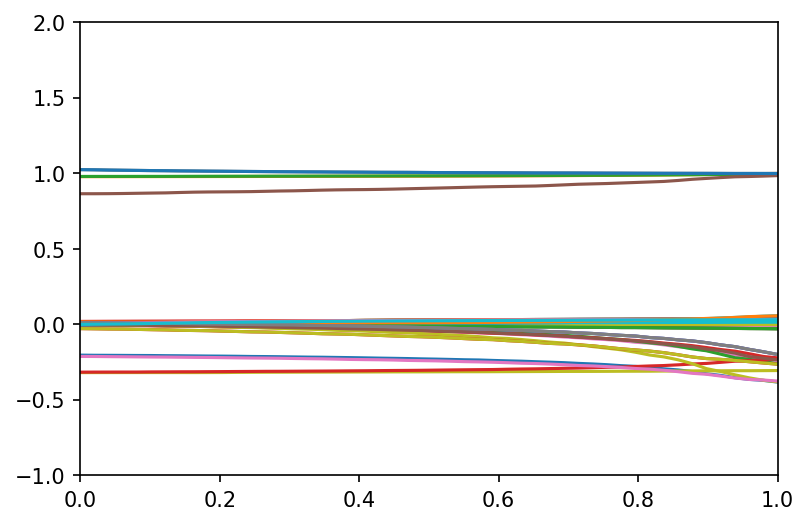

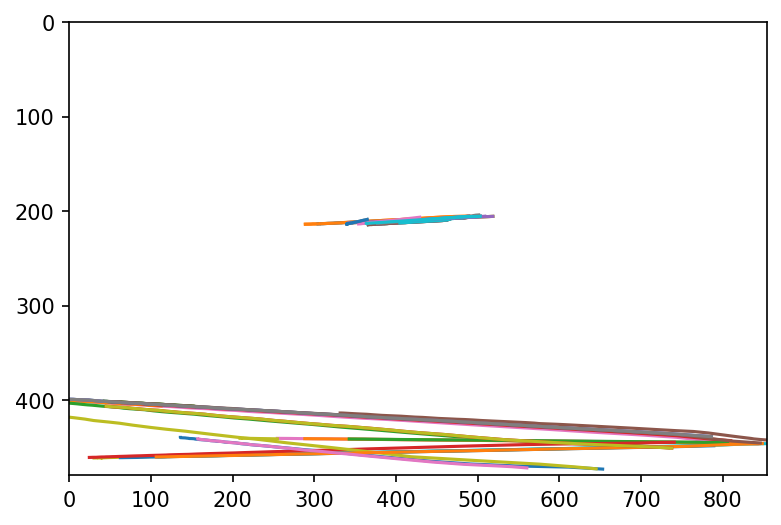

In [65]:
ano_wrongentry = wrong_entry_anomalies(tracks_interpolated, 50, entries, exits, connections)
plot_tracks(ano_wrongentry, 854, 480)

# 37 min

In [28]:
tracks = import_tracks_from_sequence("/content/drive/MyDrive/rtf_full_output_trajectories.txt")

finished reading the file
number of tracks is  6307
track length mean, std, and median are: 108.11304899318218 88.75165136556843 93.0


number of tracks is  2580
track length mean, std, and median are: 116.2984496124031 61.55748619074231 97.0
number of tracks is  2580
track length mean, std, and median are: 96.0 0.0 96.0


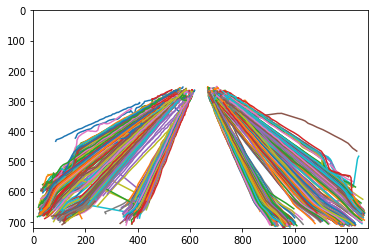

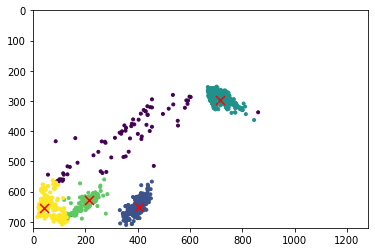

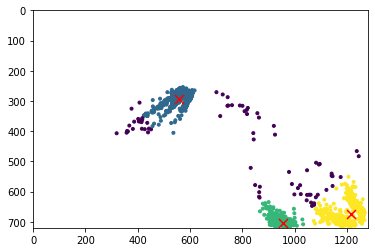

((1, 2), 0.4070578580221584)
((1, 1), 0.19121871153057038)
((3, 0), 0.1469019286007386)
((0, 0), 0.1407468198604842)
((2, 0), 0.11407468198604842)
((0, 1), 0.0)
((0, 2), 0.0)
((1, 0), 0.0)
((2, 1), 0.0)
((2, 2), 0.0)
((3, 1), 0.0)
((3, 2), 0.0)
[(1, 2), (1, 1), (3, 0), (0, 0), (2, 0)]


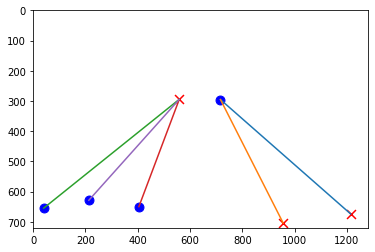

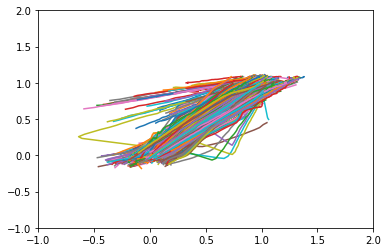

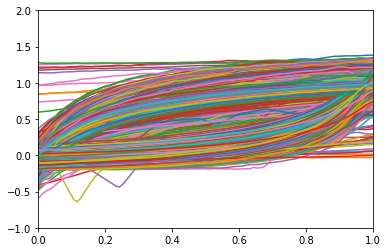

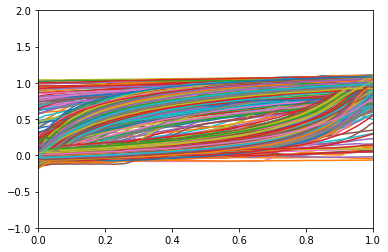

In [29]:

tracks_filtered = filter_tracks(tracks, 50, 20, 100)
tracks_interpolated = {id: interpolate_track(track, 96) for (id, track) in tracks_filtered.items()}
#print (tracks_interpolated)
tracks_print_basic_stats(tracks_interpolated)
plot_tracks(tracks_interpolated, 1280, 720)
entries, exits, connections = tracks_stats(tracks_interpolated, 1280, 720, min_samples = 0.08)
normalize_tracks(tracks_interpolated, entries, exits, connections)

In [ ]:
export_trajectories(tracks_interpolated, "track_37min_new/regular_37min") 

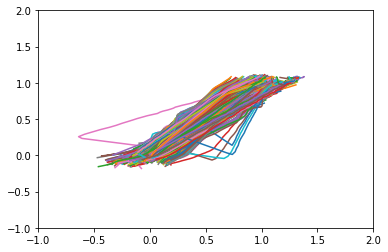

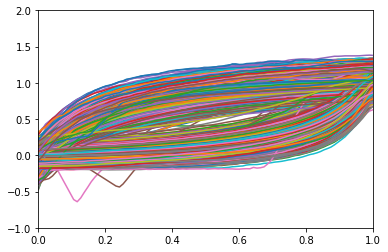

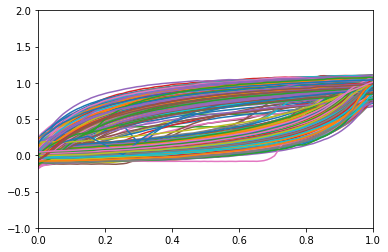

In [ ]:
nice_tracks = get_nice_trajectories(tracks_interpolated, entries, exits)
plot_normalized_tracks(nice_tracks)


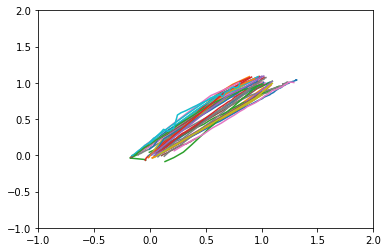

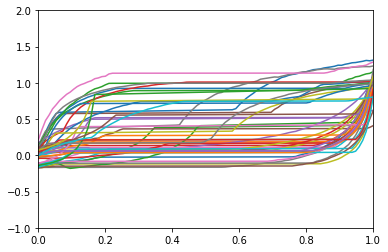

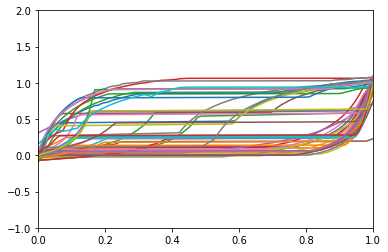

In [ ]:
ano_tracks_pause = pause_anomalies(tracks_interpolated, 50, 50, 500)

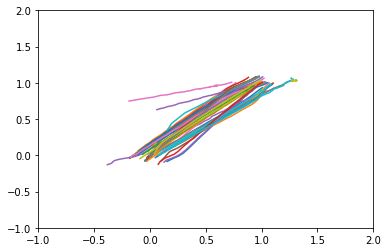

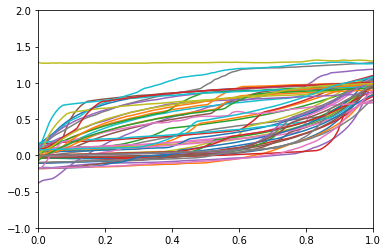

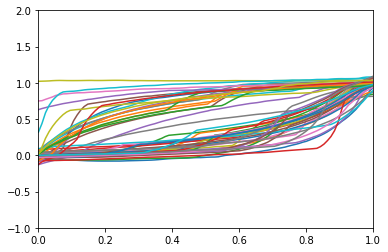

In [ ]:
ano_speedups = speedup_anomalies(tracks_interpolated, 50, 8., 16., 20, 60)

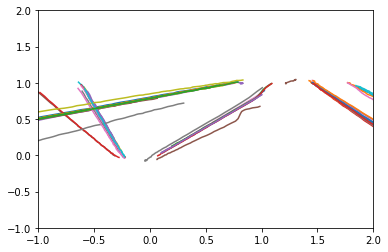

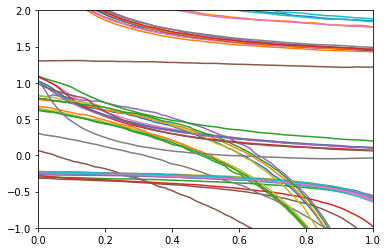

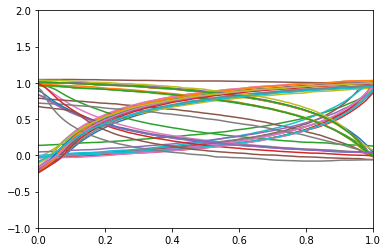

In [ ]:
ano_timeflip = reversetime_anomalies(tracks_interpolated, 50, entries, exits, connections)

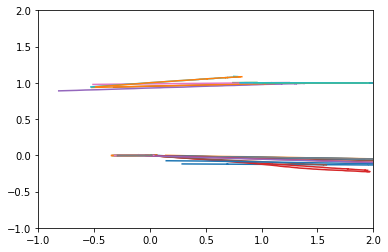

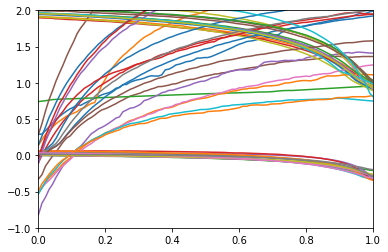

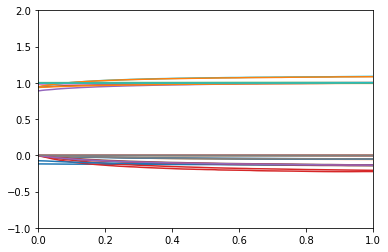

In [ ]:
ano_wrongexit = wrong_exit_anomalies(tracks_interpolated, 50, entries, exits, connections)

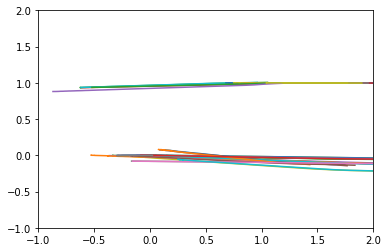

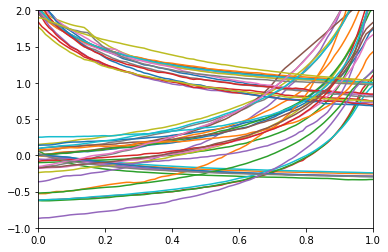

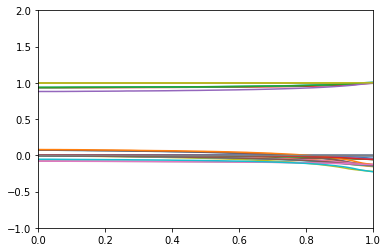

In [ ]:
ano_wrongentry = wrong_entry_anomalies(tracks_interpolated, 50, entries, exits, connections)

In [ ]:
export_trajectories(ano_tracks_pause, "track_37min_new/anomaly_pause_37min")

In [ ]:
export_trajectories(ano_speedups, "track_37min_new/anomaly_speedup_37min")

In [ ]:
export_trajectories(ano_timeflip, "track_37min_new/anomaly_timeflip_37min")

In [ ]:
export_trajectories(ano_wrongentry, "track_37min_new/anomaly_wrongentry_37min")

In [ ]:
export_trajectories(ano_wrongexit, "track_37min_new/anomaly_wrongexit_37min")

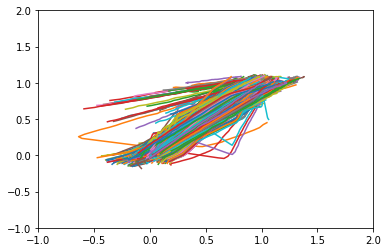

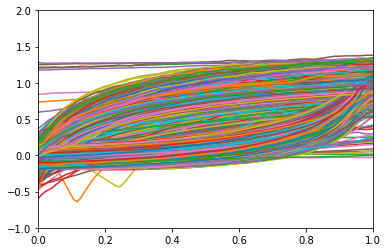

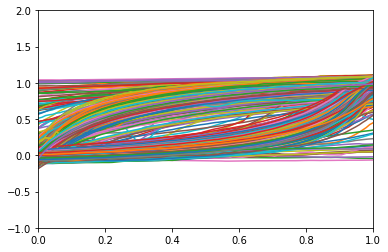

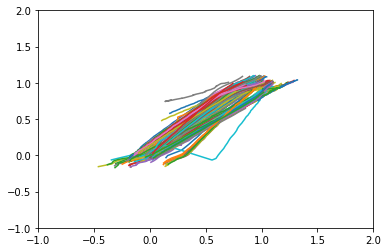

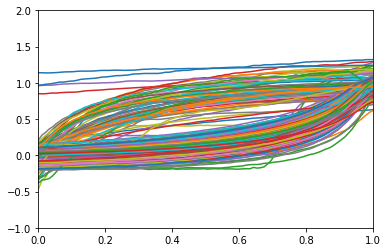

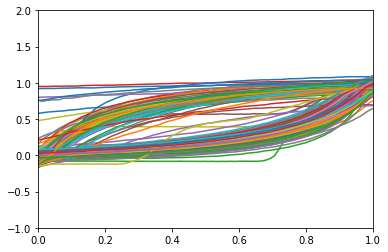

In [31]:
split_before = dict()
split_after = dict()
splitframe = 4500
for id, track in tracks_interpolated.items():
  if track["frames"][0] > splitframe:
    split_after[id] = track
  elif track["frames"][-1] < splitframe:
    split_before[id] = track

plot_normalized_tracks(split_after)
plot_normalized_tracks(split_before)

In [ ]:
export_trajectories(split_before, "split_trafficjam_37min")
export_trajectories(split_after, "split_nojam_37min")

#Lanes joining-in sequence


In [ ]:
tracks = import_tracks_from_sequence("/content/drive/MyDrive/aaa/nohayway_720_output_trajectories.txt")

finished reading the file
number of tracks is  633
track length mean, std, and median are: 171.26698262243286 401.00596624041106 112.0


number of tracks is  200
track length mean, std, and median are: 255.435 649.2787119373313 183.0
number of tracks is  200
track length mean, std, and median are: 69.0 0.0 69.0


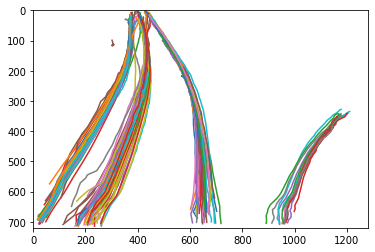

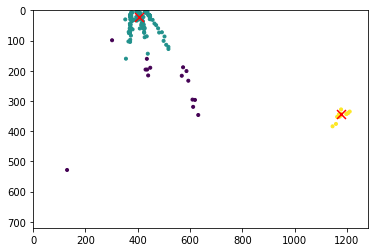

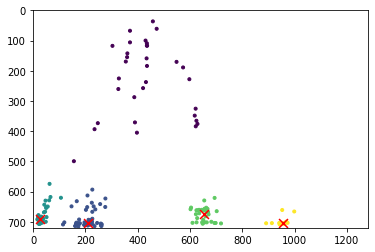

((0, 1), 0.4620253164556962)
((0, 0), 0.27848101265822783)
((0, 2), 0.17721518987341772)
((1, 3), 0.08227848101265822)
((0, 3), 0.0)
((1, 0), 0.0)
((1, 1), 0.0)
((1, 2), 0.0)
[(0, 1), (0, 0), (0, 2), (1, 3)]


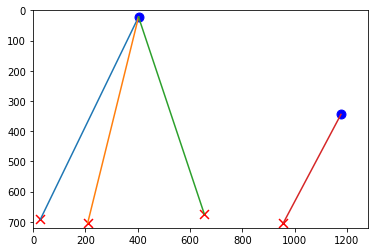

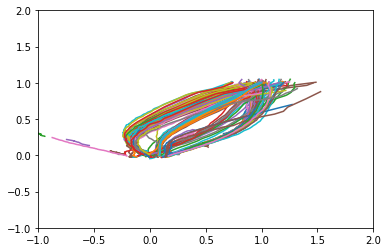

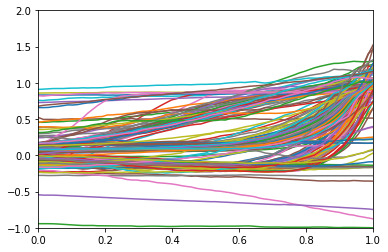

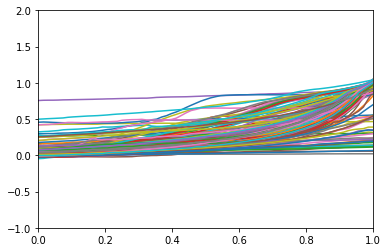

In [ ]:
tracks_filtered = filter_tracks(tracks, 50, 20, 100)
tracks_interpolated = {id: interpolate_track(track, 69) for (id, track) in tracks_filtered.items()}
#print (tracks_interpolated)
tracks_print_basic_stats(tracks_interpolated)
plot_tracks(tracks_interpolated, 1280, 720)
entries, exits, connections = tracks_stats(tracks_interpolated, 1280, 720, min_samples = 0.05)
normalize_tracks(tracks_interpolated, entries, exits, connections)